In [1]:
import os
import shutil
import utilities as rocku
import matplotlib.pyplot as plt
import tomopy
import numpy as np
import pandas as pd
import pprint
import dxchange

olefile module not found


In [2]:
# need to change
ipts="27734"
# scan_type = 'ct_scans'
scan_type = 'radiographs'

In [3]:
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/" + scan_type
os.listdir(scan_loc)

['2022_09_30_epi_screen3',
 '2022_09_30_high_res_gadox',
 '2022_09_30_box_setup',
 '2022_10_18_epi_scintillators',
 '2022_10_18_bee_low_res',
 '2022_09_30_epi_screen4',
 '2022_09_30_epi_screen1',
 '2022_09_30_high_res_gadox_LiF',
 '2022_09_30_epi_screen2']

In [4]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
os.listdir(ob_loc)

['2022_09_30_high_res_gadox',
 '2022_10_03_battery',
 '2022_10_18_epi_scintillators',
 '2022_09_30_bee',
 '2022_09_30_high_res_gadox_LiF']

In [5]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
os.listdir(dc_loc)

['2022_10_14_high_res',
 '2022_10_12_low_res',
 '2022_10_13_low_res',
 '2022_09_30_power_cycle',
 '2022_09_30_0C',
 '2022_09_30']

In [6]:
###################### need to change start
sample_name = "2022_09_30_high_res_gadox"
scan_dir = os.path.join(scan_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_09_30_high_res_gadox")
dc_dir = os.path.join(dc_loc, "2022_10_14_high_res")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
###################### need to change end

# Preprocess CT scan files

In [7]:
fname_list = os.listdir(scan_dir)
fname_list.pop(0)
fname_list

['20220930_gadox_0030_0177.tiff',
 '20220930_gadox_0030_0180.tiff',
 '20220930_gadox_0030_0183.tiff',
 '20220930_gadox_0030_0181.tiff',
 '20220930_gadox_0030_0182.tiff',
 '20220930_gadox_0030_0185.tiff',
 '20220930_gadox_0030_0179.tiff',
 '20220930_gadox_0030_0186.tiff',
 '20220930_gadox_0030_0178.tiff',
 '20220930_gadox_0030_0184.tiff']

(10, 6388, 9576)


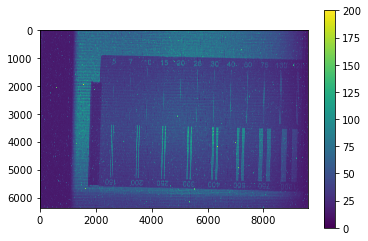

Loading Open Beam (OB)...
Loading Open Beam (OB)...Done!
(10, 6388, 9576)


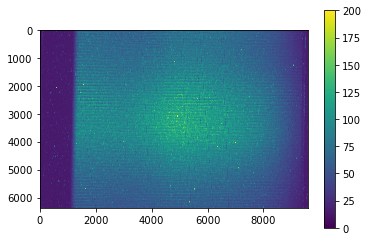

Loading Dark Current (DC)...
Loading Dark Current (DC)...Done!
(27, 6388, 9576)


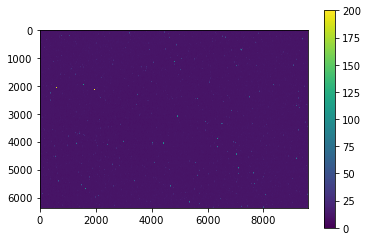

In [8]:
######### Scan
scan_raw = rocku.read_tiff_stack(scan_dir, fname_list)
print(scan_raw.shape)
plt.imshow(scan_raw[0], vmin=0, vmax=200)
plt.colorbar()
plt.show()
######### OB
ob_raw = rocku.load_ob(ob_dir, name="ob*")
print(ob_raw.shape)
plt.imshow(ob_raw[0], vmin=0, vmax=200)
plt.colorbar()
plt.show()
######### DC
dc_raw = rocku.load_dc(dc_dir, name="df*")
print(dc_raw.shape)
plt.imshow(dc_raw[0], vmin=0, vmax=200)
plt.colorbar()
plt.show()

# Crop ROI

/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tomopy/prep/alignment.py:575: RuntimeWarning: divide by zero encountered in log
  img = medfilt2d(np.log(img.astype(np.float64)),
/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


First radiograph:


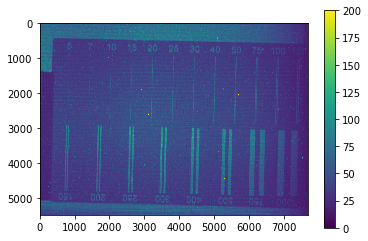

Last radiograph:


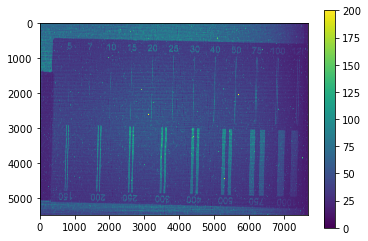

In [9]:
slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=scan_raw[0], method='simple')
roi_corners = rocku.set_roi(corners=slit_box_corners, xmin=1800, ymin=500, xmax=9500, ymax=6000)
scan_crop = tomopy.prep.alignment.remove_slits_aps_1id(scan_raw, roi_corners)
print("First radiograph:")
plt.imshow(scan_crop[0], vmin=0, vmax=200)
plt.colorbar()
plt.show()
print("Last radiograph:")
plt.imshow(scan_crop[-1], vmin=0, vmax=200)
plt.colorbar()
plt.show()

# Preprocess OB

Loading OB ...
Cropping ...
Removing outliers ...
Combining with median ...


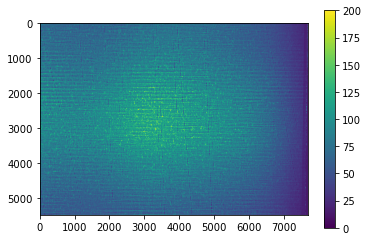

In [10]:
print('Loading OB ...')
ob_stack = rocku.read_tiff_stack(ob_dir, os.listdir(ob_dir))
print('Cropping ...')
ob_stack_crop = tomopy.prep.alignment.remove_slits_aps_1id(ob_stack, roi_corners)
print('Removing outliers ...')
ob_stack_cleaned = tomopy.remove_outlier(ob_stack_crop, gamma_diff)
print('Combining with median ...')
ob_med = np.median(ob_stack_cleaned, axis=0).astype(np.ushort)
plt.imshow(ob_med, vmin=0, vmax=200)
plt.colorbar()
plt.show()

# Preprocess DC

Loading DC ...
Cropping ...
Removing outliers ...
Combining with median ...


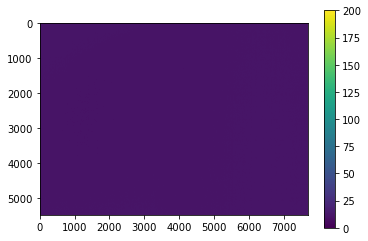

In [11]:
print('Loading DC ...')
dc_stack = rocku.read_tiff_stack(dc_dir, os.listdir(dc_dir))
print('Cropping ...')
dc_stack_crop = tomopy.prep.alignment.remove_slits_aps_1id(dc_stack, roi_corners)
print('Removing outliers ...')
dc_stack_cleaned = tomopy.remove_outlier(dc_stack_crop, gamma_diff)
print('Combining with median ...')
dc_med = np.median(dc_stack_cleaned, axis=0).astype(np.ushort)
plt.imshow(dc_med, vmin=0, vmax=200)
plt.colorbar()
plt.show()

# Normalize

Removing outliers ...
Normalizing ...


/tmp/ipykernel_135235/413239748.py:8: RuntimeWarning: divide by zero encountered in divide
  scan_norm = np.true_divide(scan, ob)
/tmp/ipykernel_135235/413239748.py:8: RuntimeWarning: invalid value encountered in divide
  scan_norm = np.true_divide(scan, ob)


float32


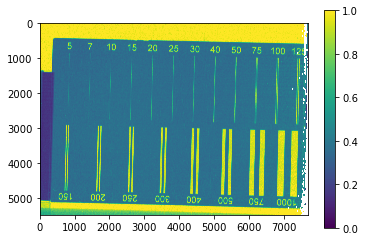

In [12]:
print('Removing outliers ...')
scan_cleaned = tomopy.remove_outlier(scan_crop, gamma_diff)
scan_cleaned = tomopy.remove_nan(scan_cleaned)
scan_cleaned = tomopy.remove_neg(scan_cleaned)
print('Normalizing ...')
ob = ob_med - dc_med
scan = scan_cleaned - dc_med
scan_norm = np.true_divide(scan, ob)
print(scan_norm.dtype)
plt.imshow(scan_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Save files

In [13]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/normalized/" + sample_name
for i, e_name in enumerate(fname_list):
    fname = save_to + "/" + e_name
    print('Saving to {} ...'.format(fname))
    dxchange.write_tiff(scan_norm[i], fname=fname, overwrite=True)

print('Combining with median ...')
scan_med = np.median(scan_norm, axis=0)
print(scan_med.dtype)
dxchange.write_tiff(scan_med, fname=save_to + "/MED", overwrite=True)
dxchange.write_tiff(ob, fname=save_to + "/OB_DC", overwrite=True)
dxchange.write_tiff(dc_med, fname=save_to + "/DC", overwrite=True)

Saving to /HFIR/CG1D/IPTS-27734/shared/autoreduce/normalized/2022_09_30_high_res_gadox/20220930_gadox_0030_0177.tiff ...
Saving to /HFIR/CG1D/IPTS-27734/shared/autoreduce/normalized/2022_09_30_high_res_gadox/20220930_gadox_0030_0180.tiff ...
Saving to /HFIR/CG1D/IPTS-27734/shared/autoreduce/normalized/2022_09_30_high_res_gadox/20220930_gadox_0030_0183.tiff ...
Saving to /HFIR/CG1D/IPTS-27734/shared/autoreduce/normalized/2022_09_30_high_res_gadox/20220930_gadox_0030_0181.tiff ...
Saving to /HFIR/CG1D/IPTS-27734/shared/autoreduce/normalized/2022_09_30_high_res_gadox/20220930_gadox_0030_0182.tiff ...
Saving to /HFIR/CG1D/IPTS-27734/shared/autoreduce/normalized/2022_09_30_high_res_gadox/20220930_gadox_0030_0185.tiff ...
Saving to /HFIR/CG1D/IPTS-27734/shared/autoreduce/normalized/2022_09_30_high_res_gadox/20220930_gadox_0030_0179.tiff ...
Saving to /HFIR/CG1D/IPTS-27734/shared/autoreduce/normalized/2022_09_30_high_res_gadox/20220930_gadox_0030_0186.tiff ...
Saving to /HFIR/CG1D/IPTS-27734/

/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


float32
